# Improved Code Summarization
> "In this tutorial you'll learn about how to apply state of the art summarization models to source code!"

- toc: true
- badges: true
- comments: true
- categories: [code, summarization, deep-learning, seq2seq]
- image: images/code_commenting.png

# About
Hi there, in this post you'll learn how to finetune the a RoBERT based model that's been trained on code data to automatically generate comments for code!

We will be focusing on the Java programming language, but you can apply the same techniques in this post for any programming language that interests you. Additionally, you'll see how to incorporate this code commenter into a [VSCode](https://code.visualstudio.com/) extension so that you can generate comments for code snippets you highlight:

(Insert GIF of tool working)

As always, we'll start with a bit of background of the data and model we are using, but feel free to skip if you want to get straight to the awesomeness ;). Alright, let's GO!

# Background

## Data
We will be using the awesome [CodeSearchNet](https://github.com/github/codesearchnet) Challenge dataset, which contains millions of pairs of methods and their docstrings for a large variety of programming languages. The dataset was initially constructed for evaluating how well different approaches perform at searching for code. However, we can easily repurpose it for us and lucky for us, the awesome authors did an awesome job collecting, documenting, and cleaning the data.

We'll be performing a bit more cleaning and formatting of the data as well as adding some more examples. These examples won't be method/docstring pairs, but code snippet/inline comment pairs. This allows our model to generate comments for arbitrary code snippets that a developer may want to document instead of just generating the docstring of a method.

## CodeBERT
The pretrained model we will be finetuning comes from the awesome paper from Microsoft's research division aptly named [CodeBERT: A Pre-Trained Model for Programming and Natural Languages](https://arxiv.org/abs/2002.08155). This model also used the CodeSearchNet challenge dataset, but instead of using it to generate comments it used to teach a RoBERTa based model to represent code and natural language in a useful way. This practice of eaching these large language models to represent text in a useful way is common practice now since these representations have been shown to be helpful in finetuning these models on other tasks. The CodeBERT paper showed these representations are helpful by finetuning them on the programming task of code search and comment generation, exactly what we will be doing! The difference between their comment generation task and ours is that we will do a bit more preprocessing and our model will be able to generate inline comments of code snippets and not just method level comments.

So, how does CodeBERT learn these representations? It combines two different training objectives that's been shown to be useful for natural language. The Masked Language Modeling objective (MLM), which is from the original [BERT](https://arxiv.org/abs/1810.04805) paper, and Replaced Token Detection (RTD) objective, which is from the [ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators](https://arxiv.org/abs/2003.10555) paper. The MLM objective is where we randomly mask out parts of the text that we feed into the model and ask the model to predict those masked out pieces. The RTD objective is where random tokens in the text are replaced and the model has to determine which of these tokens are replaced. However, to make it harder for the model, these replaced tokens attempt to be plausible alternatives and not just random words. The CodeBERT model actually used a n-gram based model to generate these alternatives where as the ELECTRA paper used a small BERT based model.

![ELECTRA Pretraining Objective](https://nathancooper.io/i-am-a-nerd/images/electra.png) (From ELECTRA Paper)

Instead of using only natural language to apply these training objectives to, CodeBERT used code and docstrings. This allowed the CodeBERT model to learn a useful representation of code that could be used for other tasks.

Alright with that quick background knowledge down, lets get into actually finetuning our model!


In [1]:
! nvidia-smi

Sun Dec 12 16:49:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/MyDrive/codecomm

/content/drive/.shortcut-targets-by-id/1OB-KmO0m7ZFl8iLQkp0FFzkjCII2_eFy/codecomm


# Data

First we'll install the necessary packages and download our data!

In [4]:
# collapse
# Download and install the necessary dependencies
! pip install -q torch==1.4.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html
! pip install -q transformers==3.5.0 fast-trees

# ! git clone -q https://github.com/microsoft/CodeXGLUE.git

# Download the CodeSearchNet Challenge dataset for the Java programming language
# ! wget -q https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip
# ! unzip -qq python.zip

     |████████████████████████████████| 753.4 MB 6.9 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
     |████████████████████████████████| 1.3 MB 8.5 MB/s 
     |████████████████████████████████| 2.9 MB 71.4 MB/s 
     |████████████████████████████████| 895 kB 55.6 MB/s 
     |████████████████████████████████| 1.1 MB 31.8 MB/s 
     |████████████████████████████████| 110 kB 67.1 MB/s 
     |████████████████████████████████| 159 kB 61.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


Next let's read in our data and since these models take a long time to train, we will only select a subset of the data.

In [10]:
# collapse
import pandas as pd

from pathlib import Path
from typing import List, Optional

# Code from CodeSearchNetChallenge: https://github.com/github/CodeSearchNet/blob/master/notebooks/ExploreData.ipynb
def jsonl_list_to_dataframe(file_list, columns=['code', 'docstring']):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f,
                                   orient='records', 
                                   compression='gzip',
                                   lines=True)[columns] 
                      for f in file_list], sort=False)

def get_dfs(path: Path) -> List[pd.DataFrame]:
    """Grabs the different data splits and converts them into dataframes"""
    dfs = []
    for split in ["train", "valid", "test"]:
        files = sorted((path/split).glob("**/*.gz"))
        df = jsonl_list_to_dataframe(files).rename(columns = {'code': 'mthd', 'docstring': 'cmt'})
        dfs.append(df)
        
    return dfs

path = Path('.')
df_trn, df_val, df_tst = get_dfs(path/"python/final/jsonl")
sample = 0.01
df_trn = df_trn.sample(frac = sample)
df_val = df_val.sample(frac = sample)
df_tst = df_tst.sample(frac = sample)

len(df_trn), len(df_val), len(df_tst)

(4122, 231, 222)

Let's see how the data looks. As shown, we have the data in a good format with one column all of the methods (input into the model) and the other all of the comments (output of the model).

In [11]:
df_trn.head()

,mthd,cmt
7041,"def download_caffe_model(model_name, meta_info...",Download caffe model into disk by the given me...
6760,"def populate_items(self, request):\n ''...",populate and returns filtered items
2560,"def wait_script(name,\n source=...",Download a script from a remote source and exe...
24360,"def place(vertices_resources, nets, machine, c...",A flat Simulated Annealing based placement alg...
3576,"def _update_info(self):\n """"""\n ...",Call parent method and make sure this is in fa...


## Data Cleaning

Now, that we have the data, let's clean it! First, we'll remove any non-ascii characters to simplify the problem so that the model only has to think about generating English comments.

In [12]:
# collapse
# From https://stackoverflow.com/a/27084708/5768407
def is_ascii(s):
    '''
    Determines if the given string contains only ascii characters

    :param s: the string to check
    :returns: whether or not the given string contains only ascii characters
    '''
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

df_trn = df_trn[df_trn['mthd'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['mthd'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['mthd'].apply(lambda x: is_ascii(x))]

df_trn = df_trn[df_trn['cmt'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['cmt'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['cmt'].apply(lambda x: is_ascii(x))]

len(df_trn), len(df_val), len(df_tst)

(4058, 226, 220)

Next, we'll remove any outdated comments by checking to see if the [JavaDoc](https://www.oracle.com/java/technologies/javase/javadoc.html)'s parameter list is different from the method's parameter list. This also will remove pairs where the docstring doesn't actually document the parameters, which probably means the pairs are poor quality (you should always properly document your code :) ).

In [5]:
# collapse
!cd /content/
!pip install tree-sitter==0.19.0
!pip install -U tree-hugger PyYAML
!create_libs -c python

     |████████████████████████████████| 112 kB 8.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for tree-sitter: filename=tree_sitter-0.19.0-cp37-cp37m-linux_x86_64.whl size=300869 sha256=082b7d4b8b486ddc028a196718498df6e763cc71c5096ad594dc8ac2e005cb98
  Stored in directory: /root/.cache/pip/wheels/d2/39/e2/aec4efbd4cf3396ab98745bd4f634f348ee400b2de407cb1c6
Successfully built tree-sitter
  Attempting uninstall: tree-sitter
    Found existing installation: tree-sitter 0.2.0
    Uninstalling tree-sitter-0.2.0:
      Successfully uninstalled tree-sitter-0.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fast-trees 0.0.3 requires tree-sitter==0.2.0, but you have tree-sitter 0.19.0 which is incompatible.
     |████████████████████████████████| 596 kB 12.3 MB/s 


Now we'll add in the additional pairs of code snippets/inline comments.

P.S. One thing to note with adding these pairs is that the inline comments will appear twice in the datasets. The first in the method where the inline comment came from and the second in the target for the code snippet. This is only a problem for the training set since it allows for the model to cheat by simply remembering the inline comment from the example method it came from. However, in my testing, I found this to not be an issue and the model seems to still work well despite this problem. Just thought ya should know :).

In [13]:
# collapse
from tqdm.auto import tqdm

def get_inline_pairs(mthd):
    '''
    Get all pairs of inline comments and corresponding code snippets

    :param mthd: the method to retrieve the pairs of comments and corresponding
    code snippets from
    :returns: all pairs of comments and corresponding code snippets
    '''
    pairs = [[]]

    comment = False
    bracket = False
    indent_lvl = -1
    lines = mthd.split("\n")
    for line in lines:
        if "//" in line and not bracket and not "://" in line:
            pairs[-1].append(line)
            if '\t' in line:
                indent_lvl = line.count('\t')
            else:
                indent_lvl = line.split("//")[0].count(' ')
            comment = True
            bracket = False
        elif comment:
            if '{' in line and not bracket:
                bracket = True
                pairs[-1].append(line)
            elif '}' in line:
                line_indent = -1
                if '\t' in line:
                    line_indent = line.count('\t')
                else:
                    line_indent = line.split("//")[0].count(' ')
                if indent_lvl == line_indent:
                    pairs[-1].append(line)
                if not bracket:
                    pairs.append([])
                    comment = False
                    bracket = False
            elif line.isspace() or line == '' and not bracket:
                pairs.append([])
                comment = False
            else:
                pairs[-1].append(line)
    
    # Convert pairs into proper format of (code snippet, inline comment) dataframe
    code_snippets   = []
    comments        = []
    for pair in pairs:
        if pair and len(pair) < 5:
            code    = []
            comment = []
            skip = False
            for line in pair:
                if "TODO" in line: break
                if "//" in line:
                    comment.append(line.replace('//', ''))
                else:
                    code.append(line)
            if len(code) > 1 and len(comment) > 0:
                        code_snippets.append('\n'.join(code))
                        comments.append('\n'.join(comment))

    pairs = pd.DataFrame(zip(code_snippets, comments), columns = ["mthd", "cmt"])
    return pairs


def add_inline(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Helper function to go through all methods in a given dataframe and add all
    pairs of inline comments and corresponding code snippets

    :param df: the dataframe to retrieve and add all pairs of inline comments
    and corresponding code snippets to
    :returns: a new dataframe with the newly added pairs of inline comments and
    corresponding code snippets
    '''
    new_df = df[df['mthd'].str.contains("//")]
    all_pairs = []
    for mthd in tqdm(new_df.mthd.values):
        pairs = get_inline_pairs(mthd)
        all_pairs.append(pairs)

    df_pairs = pd.concat([pairs for pairs in all_pairs])
    return pd.concat([df, df_pairs])

df_trn = add_inline(df_trn)
df_val = add_inline(df_val)
df_tst = add_inline(df_tst)

len(df_trn), len(df_val), len(df_tst)

  0%|          | 0/237 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

(4075, 226, 220)

We'll also remove pairs where the size of the code is smaller than the comment. This is because I found that in these cases the comments contain a bunch of extra information that the model won't have access to such as how the method is being used by other methods in the software system.

In [14]:
# collapse
df_trn = df_trn[df_trn.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]
df_val = df_val[df_val.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]
df_tst = df_tst[df_tst.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]

len(df_trn), len(df_val), len(df_tst)

(4072, 226, 220)

Next, we'll remove any examples that have the special \<code> tag since these also tend to contain extra information that the model doesn't have a good hope of generating.

In [15]:
# collapse
def has_code(cmt: str) -> bool:
    '''
    Determinine if the given comment contains the HTML <code> tag

    :param cmt: the comment to check whether it contains the HTML <code> tag
    :returns: whether or not the given comment contains the HTML <code> tag
    '''
    if '<code>' in cmt: return True
    else: return False

df_trn = df_trn[~df_trn['cmt'].apply(lambda x: has_code(x))]
df_val = df_val[~df_val['cmt'].apply(lambda x: has_code(x))]
df_tst = df_tst[~df_tst['cmt'].apply(lambda x: has_code(x))]

len(df_trn), len(df_val), len(df_tst)

(4069, 226, 220)

Lastly, we're gonna remove the JavaDoc parts of the comments other than the description since that is really all we care about. The other pieces of information can usually be autogenerated or may require external knowledge to document them.

In [17]:
import re
# collapse
def remove_jdocs(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Remove the JavaDocs leaving only the description of the comment

    :param df: the pandas dataframe to remove the JavaDocs from
    :returns: a new pandas dataframe with the JavaDocs removed
    '''
    methods = []
    comments = []
    for i, row in tqdm(list(df.iterrows())):
        comment = row["cmt"]
        # Remove {} text in comments from https://stackoverflow.com/questions/14596884/remove-text-between-and-in-python/14598135
        comment = re.sub("([\{\[]).*?([\)\}])", '', comment)
        
        
        cleaned = []
        for line in comment.split('\n'):
            if "@" in line: break
            cleaned.append(line)
        comments.append('\n'.join(cleaned))
        methods.append(row["mthd"])
    new_df = pd.DataFrame(zip(methods, comments), columns = ["mthd", "cmt"])

    return new_df

df_trn = remove_jdocs(df_trn);
df_val = remove_jdocs(df_val);
df_tst = remove_jdocs(df_tst);

  0%|          | 0/4069 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

Almost there! In this step, we'll remove any HTML tags from the comments so the model doesn't have to also learn HTML. Bless those that do...

In [18]:
# collapse
def clean_html(cmt: str) -> str:
    '''
    Remove any HTML tags from a given comment

    :param cmt: the comment to remove any HTML tags from
    :returns: the comment with any HTML tags removed
    '''
    result = re.sub(r"<.?span[^>]*>|<.?code[^>]*>|<.?p[^>]*>|<.?hr[^>]*>|<.?h[1-3][^>]*>|<.?a[^>]*>|<.?b[^>]*>|<.?blockquote[^>]*>|<.?del[^>]*>|<.?dd[^>]*>|<.?dl[^>]*>|<.?dt[^>]*>|<.?em[^>]*>|<.?i[^>]*>|<.?img[^>]*>|<.?kbd[^>]*>|<.?li[^>]*>|<.?ol[^>]*>|<.?pre[^>]*>|<.?s[^>]*>|<.?sup[^>]*>|<.?sub[^>]*>|<.?strong[^>]*>|<.?strike[^>]*>|<.?ul[^>]*>|<.?br[^>]*>", "", cmt)
    return result

df_trn.cmt = df_trn.cmt.apply(clean_html)
df_val.cmt = df_val.cmt.apply(clean_html)
df_tst.cmt = df_tst.cmt.apply(clean_html)

FINALLY!! We'll make everything lower case, remove extra whitespace, remove empty comments, and remove duplicates.

In [19]:
# collapse
df_trn = df_trn.applymap(lambda x: ' '.join(x.split()).lower())
df_val = df_val.applymap(lambda x: ' '.join(x.split()).lower())
df_tst = df_tst.applymap(lambda x: ' '.join(x.split()).lower())

df_trn = df_trn[~(df_trn['cmt'] == '')]
df_val = df_val[~(df_val['cmt'] == '')]
df_tst = df_tst[~(df_tst['cmt'] == '')]

df_trn = df_trn[~df_trn['cmt'].duplicated()]
df_val = df_val[~df_val['cmt'].duplicated()]
df_tst = df_tst[~df_tst['cmt'].duplicated()]

len(df_trn), len(df_val), len(df_tst)

(4034, 220, 220)

Now let's see what the data looks like.

In [20]:
df_trn.head()

,mthd,cmt
0,"def download_caffe_model(model_name, meta_info...",download caffe model into disk by the given me...
1,"def populate_items(self, request): self._items...",populate and returns filtered items
2,"def wait_script(name, source=none, template=no...",download a script from a remote source and exe...
3,"def place(vertices_resources, nets, machine, c...",a flat simulated annealing based placement alg...
4,def _update_info(self): ])),call parent method and make sure this is in fa...


## Data Exploring

As good Data Scientists, we will also explore our data to uncover any secrets. Data can be sneaky like that :).

In [21]:
# collapse
import numpy as np

from collections import Counter
from statistics import mean, median, stdev
from transformers import AutoTokenizer

def get_counter(df: pd.DataFrame, tokenizer: AutoTokenizer, col: str) -> Counter:
    '''
    Get the counts for each token in a given pandas dataframe column

    :param df: the pandas dataframe to get the counts of tokens from
    :param tokenizer: the tokenizer to use for tokenizing the rows in the pandas
    dataframe
    :param col: the column to grab rows from when tokenizing
    :returns: the counts of each token in the given pandas dataframe
    column
    '''
    toks = []
    for i, row in df.iterrows():
        toks.extend(tokenizer.tokenize(row[col]))
            
    cnt = Counter()
    for tok in toks:
        cnt[tok] += 1  
    return cnt

tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
mthd_cnt = get_counter(df_trn, tokenizer, 'mthd')
cmt_cnt = get_counter(df_trn, tokenizer, 'cmt')
mthd_lens = df_trn.mthd.apply(lambda x: len(tokenizer.tokenize(x))).values
cmt_lens = df_trn.cmt.apply(lambda x: len(tokenizer.tokenize(x))).values
max_mthd_len = int(np.quantile(mthd_lens, 0.95))
max_cmt_len = int(np.quantile(cmt_lens, 0.95))

Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

In [22]:
# collapse
import matplotlib.pyplot as plt

def plot_counts(counts:Counter, top_k: Optional[int] = 30):
    '''
    Plot a bar chart of the most common tokens

    :param counts: the counts of each token
    :param top_k: the number of tokens to display in the plot
    '''
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

Let's look at the most common tokens in our methods and comments.

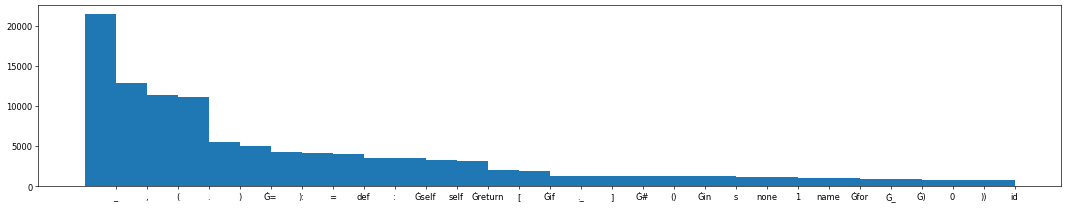

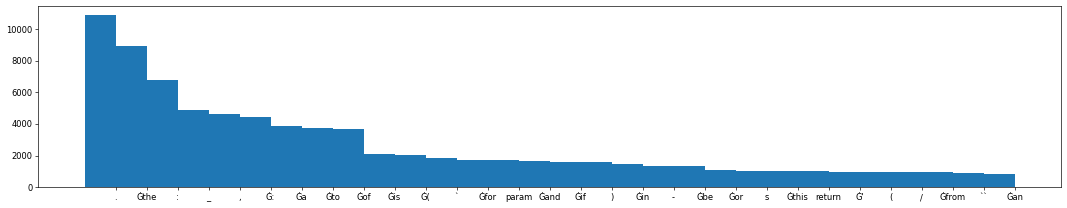

In [23]:
plot_counts(mthd_cnt, top_k = 30)
plot_counts(cmt_cnt, top_k = 30)

In [24]:
# collapse
def plot_hist(lens: List[int], n_bins: Optional[int] = 50):
    '''
    Plot a histogram of the given number of tokens in a column 

    :param lens: the number of tokens in a column
    :param n_bins: the number of bins to sort the number of tokens into
    '''
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

Now, let's look at the distribution of method and comment lengths.

61 41.0 69.91423317179414


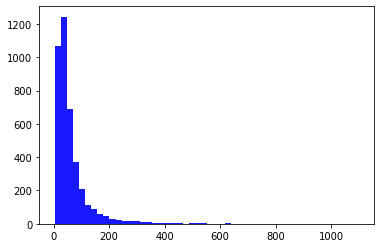

57 28.0 96.01041610158765


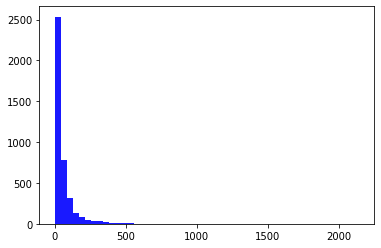

In [25]:
print(mean(mthd_lens), median(mthd_lens), stdev(mthd_lens))
plot_hist(mthd_lens)
print(mean(cmt_lens), median(cmt_lens), stdev(cmt_lens))
plot_hist(cmt_lens)

Using this new information on the length distribution, we can remove outliers by filter by lengths of methods that fall outside of 95th percentile (chosen for completely arbitrary reasons)!

In [26]:
# collapse
def filter_len(
    row: pd.Series, tokenizer: AutoTokenizer, mthd_len: int, cmt_len: int
    ) -> bool:
    '''
    Determine if a given panda dataframe row has a method or comment that has
    more tokens than max length

    :param row: the row to check if it has a method or comment that is too long
    :param tokenizer: the tokenizer to tokenize a method or comment
    :param mthd_len: the max number of tokens a method can have
    :param cmt_len: the max number of tokens a comment can have
    :returns: whether or not the given row have a method or comment that have
    more tokens than a max length
    '''
    return len(tokenizer.tokenize(row.mthd)) < mthd_len and len(tokenizer.tokenize(row.cmt)) < cmt_len

df_trn = df_trn[df_trn.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]
df_val = df_val[df_val.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]
df_tst = df_tst[df_tst.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]

len(df_trn), len(df_val), len(df_tst)

(3660, 198, 197)

In [27]:
max_mthd_len, max_cmt_len

(179, 208)

We could do a lot more exploring of our data as the above exploration was the bare minimum. As an exercise, I suggest for you to explore the data on your own using whatever means necessary!

# Training

Now that we have our data processed and in a format we like, let's go ahead and start training! To accomplish this we will be using code from the awesome [CodeXGLUE](https://github.com/microsoft/CodeXGLUE) repository. This repository is similar to the NLP equivalent GLUE benchmarks where a ton of awesome code related benchmarks are standardized and put into one place for the community to use! They have a ton of interesting ones and I highly suggest looking through their repo if you are interested in other code related tasks.

In [28]:
#%cd ./CodeXGLUE/Code-Text/code-to-text/code
%cd /content/drive/MyDrive/codecomm/CodeToCommentGenerator-master/code

/content/drive/.shortcut-targets-by-id/1OB-KmO0m7ZFl8iLQkp0FFzkjCII2_eFy/codecomm/CodeToCommentGenerator-master/code


In [ ]:
# hide
! mkdir python

Okay, I lied, sorry :(. One last processing step is required of our data, which is to just output the data into the structure that the awesome CodeXGLUE Code-Text benchmark expects.

In [29]:
# collapse
import json

df_trn['code_tokens'] = df_trn.mthd.apply(lambda x: x.split())
df_trn['docstring_tokens'] = df_trn.cmt.apply(lambda x: x.split())
with open('python/train.jsonl','w') as f:
    for _, row in df_trn.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

df_val['code_tokens'] = df_val.mthd.apply(lambda x: x.split())
df_val['docstring_tokens'] = df_val.cmt.apply(lambda x: x.split())
with open('python/valid.jsonl','w') as f:
    for _, row in df_val.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

df_tst['code_tokens'] = df_tst.mthd.apply(lambda x: x.split())
df_tst['docstring_tokens'] = df_tst.cmt.apply(lambda x: x.split())
with open('python/test.jsonl','w') as f:
    for _, row in df_tst.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

In [ ]:
lang = 'python' # programming language
lr = 5e-5
batch_size = 16 # change depending on the GPU Colab gives you
beam_size = 10
source_length = 256
target_length = max_cmt_len
data_dir = '.'
output_dir = f'model/{lang}'
train_file = f'{data_dir}/{lang}/train.jsonl'
dev_file = f'{data_dir}/{lang}/valid.jsonl'
epochs = 5 
pretrained_model = 'microsoft/codebert-base'
load_model_path = f'model/{lang}/checkpoint-best-bleu/pytorch_model.bin'

! python run.py \
    --do_train \
    --do_eval \
    --do_lower_case \
    --model_type roberta \
    --model_name_or_path {pretrained_model} \
    --train_filename {train_file} \
    --dev_filename {dev_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --train_batch_size {batch_size} \
    --eval_batch_size {batch_size} \
    --learning_rate {lr} \
    --num_train_epochs {epochs} \
    --load_model_path {load_model_path}

Traceback (most recent call last):
  File "run.py", line 65, in <module>
    parser.set_language(LANGUAGE) 
ValueError: Incompatible Language version 13. Must not be between 9 and 12


Yay! Our model has finished baking and we can now see how well it turned out by evaluating it!

In [ ]:
batch_size=64
lang = 'python' # programming language
data_dir = '.'
beam_size = 10
source_length = 256
target_length = max_cmt_len
output_dir = f'model/{lang}_new' #f'model/{lang}'
dev_file=f"{data_dir}/{lang}/valid.jsonl"
test_file=f"{data_dir}/{lang}/test.jsonl"
test_model=f"{output_dir}/checkpoint-best-bleu/pytorch_model.bin" #checkpoint for test

! python run.py \
    --do_test \
    --model_type roberta \
    --model_name_or_path microsoft/codebert-base \
    --load_model_path {test_model} \
    --dev_filename {dev_file} \
    --test_filename {test_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --eval_batch_size {batch_size}

12/11/2021 23:47:21 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=10, config_name='', dev_filename='./python/valid.jsonl', do_eval=False, do_lower_case=False, do_test=True, do_train=False, eval_batch_size=64, eval_steps=-1, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path='model/python_new/checkpoint-best-bleu/pytorch_model.bin', local_rank=-1, max_grad_norm=1.0, max_source_length=256, max_steps=-1, max_target_length=197, model_name_or_path='microsoft/codebert-base', model_type='roberta', no_cuda=False, num_train_epochs=3, output_dir='model/python_new', seed=42, test_filename='./python/test.jsonl', tokenizer_name='', train_batch_size=8, train_filename=None, train_steps=-1, warmup_steps=0, weight_decay=0.0)
12/11/2021 23:47:21 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
12/11/2021 23:47:25 - INFO - __main__ -   reload model from model/python_new/checkpoint-best-bleu/pytorch_model.bin
12/11/2021 23:47:2

In [ ]:
pretrained_model = 'microsoft/codebert-base'

Let's now load up our model and take it for a spin!

In [ ]:
# collapse
import torch

import torch.nn as nn

from model import Seq2Seq
from transformers import RobertaConfig, RobertaModel

config = RobertaConfig.from_pretrained(pretrained_model)
encoder = RobertaModel.from_pretrained(pretrained_model, config = config)    
decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
# decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=8)
model = Seq2Seq(encoder = encoder,decoder = decoder,config=config,
                beam_size=beam_size,max_length=target_length,
                sos_id=tokenizer.cls_token_id,eos_id=tokenizer.sep_token_id)
model.load_state_dict(torch.load(Path(output_dir)/"checkpoint-last/pytorch_model.bin"))
model.to('cuda')

Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [ ]:
idx = 0
TEXT_TO_SUMMARIZE = df_val.mthd.values[idx]
print('Code:', TEXT_TO_SUMMARIZE)
print('Original Comment:', df_val.cmt.values[idx])

Code: def config2(self): """read the second set of configuration variables and return as a dictionary. **note: this method is supported by firmware v18+.** :rtype: dictionary :example: >>> a.config2() { 'amfanonidle': 0, 'amidleintervalcount': 0, 'ammaxdataarraysinfile': 61798, 'amsamplinginterval': 1, 'amonlysavepmdata': 0, 'amlaseronidle': 0 } """ config = [] data = {} # send the command byte and sleep for 10 ms self.cnxn.xfer([0x3d]) sleep(10e-3) # read the config variables by sending 256 empty bytes for i in range(9): resp = self.cnxn.xfer([0x00])[0] config.append(resp) data["amsamplinginterval"] = self._16bit_unsigned(config[0], config[1]) data["amidleintervalcount"] = self._16bit_unsigned(config[2], config[3]) data['amfanonidle'] = config[4] data['amlaseronidle'] = config[5] data['ammaxdataarraysinfile'] = self._16bit_unsigned(config[6], config[7]) data['amonlysavepmdata'] = config[8] sleep(0.1) return data
Original Comment: read the second set of configuration variables and retu

In [ ]:
# collapse
from run import convert_examples_to_features, Example

class Args:
    max_source_length = source_length
    max_target_length = target_length

args = Args()

def get_preds(df: pd.DataFrame):
    ps = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor(eval_features[0].source_ids, dtype = torch.long).unsqueeze(0).to('cuda')
        source_mask = torch.tensor(eval_features[0].source_mask, dtype = torch.long).unsqueeze(0).to('cuda')

        with torch.no_grad():
            preds = model(source_ids = source_ids, source_mask = source_mask)  
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
    
    return ps

In [ ]:
df_val = df_val.reset_index()
preds = get_preds(df_val.head(10))
for idx, row in df_val.head(10).iterrows():
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', preds[idx])
    print('='*40)

  0%|          | 0/10 [00:00<?, ?it/s]

Code: def config2(self): """read the second set of configuration variables and return as a dictionary. **note: this method is supported by firmware v18+.** :rtype: dictionary :example: >>> a.config2() { 'amfanonidle': 0, 'amidleintervalcount': 0, 'ammaxdataarraysinfile': 61798, 'amsamplinginterval': 1, 'amonlysavepmdata': 0, 'amlaseronidle': 0 } """ config = [] data = {} # send the command byte and sleep for 10 ms self.cnxn.xfer([0x3d]) sleep(10e-3) # read the config variables by sending 256 empty bytes for i in range(9): resp = self.cnxn.xfer([0x00])[0] config.append(resp) data["amsamplinginterval"] = self._16bit_unsigned(config[0], config[1]) data["amidleintervalcount"] = self._16bit_unsigned(config[2], config[3]) data['amfanonidle'] = config[4] data['amlaseronidle'] = config[5] data['ammaxdataarraysinfile'] = self._16bit_unsigned(config[6], config[7]) data['amonlysavepmdata'] = config[8] sleep(0.1) return data
Original Comment: read the second set of configuration variables and retu

The model seems to be doing a good job, but if you play with it some more you'll realize it is mostly taking the name of the method and using that to guide the comment. This makes sense, but it probably isn't learning much more than this association, at least with this small model. Let's explore it a bit more by looking at all the examples in the validation set it is failing the most on.

In [ ]:
def get_preds_losses(df: pd.DataFrame):
    ps = []
    losses = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor([f.source_ids for f in eval_features], dtype = torch.long).to('cuda')
        source_mask = torch.tensor([f.source_mask for f in eval_features], dtype = torch.long).to('cuda')
        target_ids = torch.tensor([f.target_ids for f in eval_features], dtype = torch.long).to('cuda')
        target_mask = torch.tensor([f.target_mask for f in eval_features], dtype = torch.long).to('cuda')

        with torch.no_grad():
            _, loss, _ = model(
                source_ids = source_ids, source_mask = source_mask,
                target_ids = target_ids, target_mask = target_mask
            )
            preds = model(source_ids = source_ids, source_mask = source_mask)  
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
                losses.append(loss.item())
    
    return ps, losses

In [ ]:
df_head = df_val.copy()
ps, losses = get_preds_losses(df_head)
df_head['pred'] = ps
df_head['loss'] = losses
df_sorted_losses = df_head.sort_values('loss', ascending = False)

for _, row in df_sorted_losses.head(10).iterrows():
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', row.pred)
    print(row.loss)
    print('='*40)

  0%|          | 0/196 [00:00<?, ?it/s]

Code: def _tzstr(self, sep=":"): """return formatted timezone offset (+xx:xx) or none.""" off = self._utcoffset() if off is not none: if off < 0: sign = "-" off = -off else: sign = "+" hh, mm = divmod(off, 60) assert 0 <= hh < 24 off = "%s%02d%s%02d" % (sign, hh, sep, mm) return off
Original Comment: return formatted timezone offset (+xx:xx) or none.
Generated Comment: return formatted timezone offset (+xx:xx) or none.
40.843360900878906
Code: def _post_start(self): """set stdout to non-blocking vlc does not always return a newline when reading status so in order to be lazy and still use the read api without caring about how much output there is we switch stdout to nonblocking mode and just read a large chunk of datin order to be lazy and still use the read api without caring about how much output there is we switch stdout to nonblocking mode and just read a large chunk of data. """ flags = fcntl.fcntl(self._process.stdout, fcntl.f_getfl) fcntl.fcntl(self._process.stdout, fcntl.f_setfl

# What's Next?

If you'd like to see how you can integrate this code comment summarizer model into the popular VSCode IDE, check out my video that goes over just that!

> youtube: https://youtu.be/SYjgPjQ-vbc

# graph code bert

In [ ]:
%cd parse
!bash build.sh
%cd ..

/content/drive/.shortcut-targets-by-id/1OB-KmO0m7ZFl8iLQkp0FFzkjCII2_eFy/codecomm/CodeToCommentGenerator-master/code/parse
Cloning into 'tree-sitter-python'...
remote: Enumerating objects: 2418, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 2418 (delta 87), reused 103 (delta 42), pack-reused 2256
Receiving objects: 100% (2418/2418), 18.31 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (1516/1516), done.
/content/drive/.shortcut-targets-by-id/1OB-KmO0m7ZFl8iLQkp0FFzkjCII2_eFy/codecomm/CodeToCommentGenerator-master/code


In [ ]:
lang = 'python' # programming language
lr = 5e-5
batch_size = 8 # change depending on the GPU Colab gives you
beam_size = 10
source_length = 256
target_length = max_cmt_len
data_dir = '.'
output_dir = f'model/{lang}_new'
train_file = f'{data_dir}/{lang}/train.jsonl'
dev_file = f'{data_dir}/{lang}/valid.jsonl'
epochs = 10 
pretrained_model = 'microsoft/graphcodebert-base'
load_model_path = f'model/{lang}/checkpoint-best-bleu/pytorch_model.bin'

! python run.py \
    --do_train \
    --do_eval \
    --do_lower_case \
    --model_type roberta \
    --model_name_or_path {pretrained_model} \
    --train_filename {train_file} \
    --dev_filename {dev_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --train_batch_size {batch_size} \
    --eval_batch_size {batch_size} \
    --learning_rate {lr} \
    --num_train_epochs {epochs} \
    --load_model_path {load_model_path}

12/12/2021 16:57:43 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=10, config_name='', dev_filename='./python/valid.jsonl', do_eval=True, do_lower_case=True, do_test=False, do_train=True, eval_batch_size=8, eval_steps=-1, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path='model/python/checkpoint-best-bleu/pytorch_model.bin', max_grad_norm=1.0, max_source_length=256, max_steps=-1, max_target_length=208, model_name_or_path='microsoft/graphcodebert-base', model_type='roberta', no_cuda=False, num_train_epochs=10, output_dir='model/python_new', seed=42, test_filename=None, tokenizer_name='', train_batch_size=8, train_filename='./python/train.jsonl', train_steps=-1, warmup_steps=0, weight_decay=0.0)
12/12/2021 16:57:43 - WARNING - __main__ -   device: cuda
Downloading: 100% 539/539 [00:00<00:00, 525kB/s]
Downloading: 100% 899k/899k [00:00<00:00, 2.80MB/s]
Downloading: 100% 456k/456k [00:00<00:00, 1.47MB/s]
Downloading: 100% 772/772 [00:00<00:00, 818kB/s]
Down

In [ ]:
batch_size=64
lang = 'python' # programming language
data_dir = '.'
beam_size = 10
source_length = 256
target_length = max_cmt_len
output_dir = f'model/{lang}' #f'model/{lang}_new' 
dev_file=f"{data_dir}/{lang}/valid.jsonl"
test_file=f"{data_dir}/{lang}/test.jsonl"
test_model=f"{output_dir}/checkpoint-best-ppl/pytorch_model.bin" #checkpoint for test

! python run.py \
    --do_test \
    --model_type roberta \
    --model_name_or_path microsoft/graphcodebert-base \
    --load_model_path {test_model} \
    --dev_filename {dev_file} \
    --test_filename {test_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --eval_batch_size {batch_size} 

12/12/2021 12:03:59 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=10, config_name='', dev_filename='./python/valid.jsonl', do_eval=False, do_lower_case=False, do_test=True, do_train=False, eval_batch_size=64, eval_steps=-1, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path='model/python/checkpoint-best-ppl/pytorch_model.bin', max_grad_norm=1.0, max_source_length=256, max_steps=-1, max_target_length=198, model_name_or_path='microsoft/graphcodebert-base', model_type='roberta', no_cuda=False, num_train_epochs=3, output_dir='model/python', seed=42, test_filename='./python/test.jsonl', tokenizer_name='', train_batch_size=8, train_filename=None, train_steps=-1, warmup_steps=0, weight_decay=0.0)
12/12/2021 12:03:59 - WARNING - __main__ -   device: cuda
Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should pro

In [ ]:
# collapse
import torch

import torch.nn as nn

from model import Seq2Seq
from transformers import RobertaConfig, RobertaModel

config = RobertaConfig.from_pretrained(pretrained_model)
encoder = RobertaModel.from_pretrained(pretrained_model, config = config)    
decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
# decoder = nn.TransformerDecoder(decoder_layer, num_layers=8)
model = Seq2Seq(encoder = encoder,decoder = decoder,config=config,
                beam_size=beam_size,max_length=target_length,
                sos_id=tokenizer.cls_token_id,eos_id=tokenizer.sep_token_id)
model.load_state_dict(torch.load(Path(output_dir)/"checkpoint-last/pytorch_model.bin"))
model.to('cuda')

Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [ ]:
idx = 0
TEXT_TO_SUMMARIZE = df_val.mthd.values[idx]
print('Code:', TEXT_TO_SUMMARIZE)
print('Original Comment:', df_val.cmt.values[idx])

Code: def authenticate(self): ) self._session_id = session_id
Original Comment: authenticate against the nuheat api


In [ ]:
# collapse
from run import convert_examples_to_features, Example, get_attn_mask

class Args:
    max_source_length = source_length
    max_target_length = target_length

args = Args()

def get_preds(df: pd.DataFrame):
    ps = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor(eval_features[0].source_ids, dtype = torch.long).unsqueeze(0).to('cuda')
        source_mask = torch.tensor(eval_features[0].source_mask, dtype = torch.long).unsqueeze(0).to('cuda')
        att_mask = torch.tensor(get_attn_mask(eval_features[0], args), dtype = torch.bool).unsqueeze(0).to('cuda') 
        position_idx = torch.tensor(eval_features[0].position_idx, dtype = torch.long).unsqueeze(0).to('cuda')

        with torch.no_grad():
            preds = model(source_ids = source_ids, source_mask = source_mask, position_idx=position_idx, attn_mask = att_mask)  
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
    
    return ps

In [ ]:
# df_val = df_val.reset_index()
preds = get_preds(df_val.head(10))
for idx, row in df_val.head(10).iterrows():
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', preds[idx])
    print('='*40)

  0%|          | 0/10 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 305.95it/s]

100%|██████████| 1/1 [00:00<00:00, 521.87it/s]

100%|██████████| 1/1 [00:00<00:00, 387.32it/s]

100%|██████████| 1/1 [00:00<00:00, 126.45it/s]

100%|██████████| 1/1 [00:00<00:00, 183.37it/s]

100%|██████████| 1/1 [00:00<00:00, 348.54it/s]

100%|██████████| 1/1 [00:00<00:00, 102.90it/s]

100%|██████████| 1/1 [00:00<00:00, 190.12it/s]

100%|██████████| 1/1 [00:00<00:00, 147.45it/s]

100%|██████████| 1/1 [00:00<00:00, 46.54it/s]


Code: def authenticate(self): ) self._session_id = session_id
Original Comment: authenticate against the nuheat api
Generated Comment: session the token.
Code: def _run_paste(app, config, mode): ) return
Original Comment: run wsgidav using paste.httpserver, if paste is installed. see http://pythonpaste.org/modules/httpserver.html for more options
Generated Comment: run the command.
Code: def parse_selection(self, selection, name=none): ): # verbatim make_ndx command process = self._process_command selection = selection[1:] else: process = self._process_residue return process(selection, name)
Original Comment: retuns (groupname, filename) with index group.
Generated Comment: :param line: :return:
Code: def p_call_mixin(self, p): p[1].parse(none) p[0] = deferred(p[1], p[3], p.lineno(4))
Original Comment: call_mixin : identifier t_popen mixin_args_list t_pclose t_semicolon
Generated Comment: helper function
Code: def write_main(argv): ) out_tef.write(output_bytes) return 0
Original Commen

In [ ]:
def get_preds_losses(df: pd.DataFrame):
    ps = []
    losses = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor([f.source_ids for f in eval_features], dtype = torch.long).to('cuda')
        source_mask = torch.tensor([f.source_mask for f in eval_features], dtype = torch.long).to('cuda')
        target_ids = torch.tensor([f.target_ids for f in eval_features], dtype = torch.long).to('cuda')
        target_mask = torch.tensor([f.target_mask for f in eval_features], dtype = torch.long).to('cuda')
        att_mask = torch.tensor(get_attn_mask(eval_features[0], args), dtype = torch.bool).unsqueeze(0).to('cuda') 
        position_idx = torch.tensor(eval_features[0].position_idx, dtype = torch.long).unsqueeze(0).to('cuda')

        with torch.no_grad():
            _, loss, _ = model(
                source_ids = source_ids, source_mask = source_mask,
                position_idx = position_idx, attn_mask = att_mask,
                target_ids = target_ids, target_mask = target_mask
            )
            preds = model(source_ids = source_ids, source_mask = source_mask,  position_idx = position_idx, attn_mask = att_mask)  
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
                losses.append(loss.item())
    
    return ps, losses

In [ ]:
df_head = df_val.copy()
ps, losses = get_preds_losses(df_head)
df_head['pred'] = ps
df_head['loss'] = losses
df_sorted_losses = df_head.sort_values('loss', ascending = False)

for _, row in df_sorted_losses.head(10).iterrows():
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', row.pred)
    print(row.loss)
    print('='*40)

  0%|          | 0/203 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 365.68it/s]

100%|██████████| 1/1 [00:00<00:00, 353.20it/s]

100%|██████████| 1/1 [00:00<00:00, 287.89it/s]

100%|██████████| 1/1 [00:00<00:00, 108.74it/s]

100%|██████████| 1/1 [00:00<00:00, 107.21it/s]

100%|██████████| 1/1 [00:00<00:00, 565.35it/s]

100%|██████████| 1/1 [00:00<00:00, 102.30it/s]

100%|██████████| 1/1 [00:00<00:00, 147.45it/s]

100%|██████████| 1/1 [00:00<00:00, 129.22it/s]

100%|██████████| 1/1 [00:00<00:00, 93.56it/s]

100%|██████████| 1/1 [00:00<00:00, 85.25it/s]

100%|██████████| 1/1 [00:00<00:00, 233.73it/s]

100%|██████████| 1/1 [00:00<00:00, 382.69it/s]

100%|██████████| 1/1 [00:00<00:00, 118.48it/s]

100%|██████████| 1/1 [00:00<00:00, 110.81it/s]

100%|██████████| 1/1 [00:00<00:00, 209.04it/s]

100%|██████████| 1/1 [00:00<00:00, 675.41it/s]

100%|██████████| 1/1 [00:00<00:00, 603.32it/s]

100%|██████████| 1/1 [00:00<00:00, 109.62it/s]

100%|██████████| 1/1 [00:00<00:00, 270.86it/s]

100%|██████████| 1/1 [00:00<00:00, 89.24i

Code: def ndmeshgrid(*arrs): #arrs = tuple(reversed(arrs)) <-- wrong on stackoverflow.com arrs = tuple(arrs) lens = list(map(len, arrs)) dim = len(arrs) sz = 1 for s in lens: sz *= s ans = [] for i, arr in enumerate(arrs): slc = [1] * dim slc[i] = lens[i] arr2 = numpy.asanyarray(arr).reshape(slc) for j, sz in enumerate(lens): if j != i: arr2 = arr2.repeat(sz, axis=j) ans.append(arr2) return tuple(ans)
Original Comment: return a mesh grid for n dimensions. the input are n arrays, each of which contains the values along one axis of the coordinate system. the arrays do not have to have the same number of entries. the function returns arrays that can be fed into numpy functions so that they produce values for *all* points spanned by the axes *arrs*. original from http://stackoverflow.com/questions/1827489/numpy-meshgrid-in-3d and fixed. .. seealso: :func:`numpy.meshgrid` for the 2d case.
Generated Comment: r""" returns a numpy array of numpy array of numpy array. parameters ---------- nump